In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
from os.path import join as oj
import numpy as np
from copy import deepcopy
plt.style.use('dark_background')
import sys
sys.path.append('../src')
import data
import pickle as pkl
import viz
from viz import *
import analyze_helper, train
from sklearn import metrics
from config import *
import pandas as pd
from tqdm import tqdm
outcome_def = 'y_consec_thresh'
out_dir = oj(DIR_RESULTS, 'may7_1') # mar7_2 is 0.95, mar8_1 is 0.96
results = analyze_helper.load_results(out_dir)

# get data
df = data.get_data()
n = df.shape[0]
df_cv = df[df.valid == 1] # exclude test cells, short/long tracks, hotspots
X, y, norms = analyze_helper.normalize(df_cv, outcome_def)

# select model
r = results
r = r.sort_values('accuracy', ascending=False)
idx = np.array(r.index)
accs = np.array(r.accuracy)
# model_name = idx[0]
model_name = 'mlp2_17_select_lasso=7_ros=1_h=0_cal=True'
print('using model', model_name)
for i in range(5):
    print(f'\t{accs[i]:.3f}', idx[i])
    

# load model + preds
d_full_cv, idxs_cv = analyze_helper.get_data_over_folds(model_name, out_dir, df_cv.cell_num, X, y)
y_full_cv = df_cv[outcome_def].iloc[idxs_cv].values.astype(np.int)
preds_cv = d_full_cv[model_name].values
preds_proba_cv = d_full_cv[model_name + '_proba'].values

results_individual = pkl.load(open(oj(out_dir, f'{model_name}.pkl'), 'rb'))
assert np.sum(idxs_cv == np.arange(idxs_cv.size)) == idxs_cv.size, \
       'points not in same order'
assert np.mean(preds_cv==y_full_cv) == np.average(results_individual['cv']['accuracy'], 
                                               weights=results_individual['num_pts_by_fold_cv']), \
        'did not properly load model/data'
tp, tn, fp, fn = analyze_helper.calc_errs(preds_cv, y_full_cv)
print('succesfully loaded!')

# accuracies on different test datasets

**calculate predictions on diff datasets**

In [ ]:
orig_dset = 'clath_aux+gak_a7d2'
normalize_by_train = False
df = data.get_data()

# training data
CELLS_TRAIN = config.DSETS[orig_dset]['train']
df_train = df[df.cell_num.isin(CELLS_TRAIN)]
X_train = df_train[data.get_feature_names(df_train)]
X_mean_train = X_train.mean()
X_std_train = X_train.std()

# testing data
CELLS_TEST = config.DSETS[orig_dset]['test']
df_test = df[df.cell_num.isin(CELLS_TEST)]
X_test = df_test[data.get_feature_names(df_test)]
if normalize_by_train:
    X_test = (X_test - X_mean_train) / X_std_train
else:
    X_test = (X_test - X_test.mean()) / X_test.std()
y_test = df_test[outcome_def].values

# get model
m0 = results_individual['imps']['model'][0]
feat_names_selected = results_individual['feat_names_selected']
preds_test = m0.predict(X_test[feat_names_selected]) 
preds_proba_test = m0.predict_proba(X_test[feat_names_selected]) [:, 1]

# set up lists
dsets = ['validation', 'test']
ys_list = [y_full_cv, y_test]
preds_list = [preds_cv, preds_test]
preds_proba_list = [preds_proba_cv, preds_proba_test]
Y_max_list = [df_cv['Y_max'], df_test['Y_max']]

def normalize_and_predict(dset_name, normalize_by_train):
    df_new = data.get_data(dset=dset_name, use_processed=True,
                           use_processed_dicts=True, outcome_def=outcome_def,
                           previous_meta_file=oj(DIR_PROCESSED,
                                                 'metadata_clath_aux+gak_a7d2.pkl'))
    df_new = df_new[df_new['valid']] # exclude test cells, short/long tracks, hotspots
    
    # impute (only does anything for dynamin data)
    df_new = df_new.fillna(df_new.median())
    
    X_new = df_new[data.get_feature_names(df_new)]
    if normalize_by_train:
        X_new = (X_new - X_mean_train) / X_std_train
    else:
        X_new = (X_new - X_new.mean()) / X_new.std()
    y_new = df_new[outcome_def].values
    preds_new = m0.predict(X_new[feat_names_selected]) 
    preds_proba_new = m0.predict_proba(X_new[feat_names_selected])[:, 1]
    Y_maxes = df_new['Y_max']
    return df_new, y_new, preds_new, preds_proba_new, Y_maxes

# loop over new datasets
outcome_def = 'y_consec_thresh'
# outcome_def = 'y_rule_based'
dset_names = [k for k in config.DSETS.keys() if not k == orig_dset]
for dset_name in tqdm(dset_names):
    _, y_new, preds_new, preds_proba_new, Y_maxes = normalize_and_predict(dset_name, normalize_by_train)
    dsets.append(dset_name)
    ys_list.append(deepcopy(y_new))
    preds_list.append(deepcopy(preds_new))
    preds_proba_list.append(deepcopy(preds_proba_new))
    Y_max_list.append(Y_maxes)

**show metrics on different dsets**

In [ ]:
def roundd(x):
    try:
        return x.round(2)
    except:
        return [y.round(2) for y in x]
    
def mean_diff(vals, preds):
    return np.mean(vals[preds==1]) - np.mean(vals[preds==0])

r_long = {}
n = len(dsets)
for s in train.scorers:
    if s == 'roc_auc':
        r_long[s] = [roundd(metrics.roc_auc_score(ys_list[i],
                                                  preds_proba_list[i])) for i in range(n)]
    elif 'curve' not in s and 'acc' in s:
        r_long[s] = [roundd(train.scorers[s](ys_list[i], preds_list[i])) for i in range(n)]        
r_long['diff_aux_max_by_class'] = [mean_diff(Y_max_list[i], preds_list[i]) for i in range(n)]
r_long['aux+ ratio'] = [np.mean(ys_list[i]) for i in range(n)]

r = pd.DataFrame.from_dict(r_long).transpose()
r.columns = dsets
r.round(2)

In [ ]:
print(r.to_latex())

# diff dataset summaries

In [ ]:
# process original data (and save out lifetime thresholds)
dset_names = [k for k in sorted(config.DSETS.keys()) if not 'pi4p' in k]
# dsets = ['clath_aux', 'orig_gak', 'clath_aux_no_a7d2', 'clath_aux_a8', 'clath_pi4p_notreatment']

NUM_DSETS = len(dset_names)
rs = {
    k: [] for k in ['X_mean', 'Y_max']
}
ds = {
    k: [] for k in ['lifetime', 'Y_max']
}
for dset in tqdm(dset_names):
    # process new data (using lifetime thresholds from original data)
    df = data.get_data(dset=dset,
                  previous_meta_file='processed/metadata_orig.pkl')
    for k in rs.keys():
        rs[k].append(df[k].mean())
    for k in ds.keys():
        ds[k].append(df[k])

**means of some features**

In [ ]:
R, C = 1, 2
plt.figure(figsize=(8, 3), dpi=500)
for i, k in enumerate(rs.keys()):
    plt.subplot(R, C, i + 1)
    plt.barh(dset_names, rs[k], color=cb)
    plt.xlabel('Average ' + k)
plt.tight_layout()
plt.show()

In [ ]:
R, C = 1, len(ds.keys())
plt.figure(figsize=(8, 3), dpi=500)
for i, k in enumerate(ds.keys()):
    ax = plt.subplot(R, C, i + 1)
    # plt.barh(dset_names, [np.mean(x) for x in ds[k]], color=cb)
    ax.violinplot([val.values for val in ds[k]], vert=False,
                  widths=1, showmedians=True, showextrema=True) #, quantiles=[25, 50])
    plt.yticks(np.arange(len(dset_names)) + 1, dset_names)
    plt.xlabel(k)
    plt.xscale('log')
plt.tight_layout()
plt.show()

# lower res data

In [ ]:
accs = []
DOWNSAMPLE_list = range(1, 21)
for DOWNSAMPLE in tqdm(DOWNSAMPLE_list):

    # downsample
    df_cv = deepcopy(df[df.valid == 1]) # exclude test cells, short/long tracks, hotspots
    df_cv['X'] = [x[::DOWNSAMPLE] for x in df_cv.X]
    df_cv['X_extended'] = [x[::DOWNSAMPLE] for x in df_cv.X_extended]
    df_cv['lifetime'] = [len(x) for x in df_cv.X]
    df_cv = data.add_features(df_cv)


    # get data
    X, y, norms = analyze_helper.normalize(df_cv, outcome_def)
    d_full_cv, idxs_cv = analyze_helper.get_data_over_folds(model_name, out_dir, df_cv.cell_num, X, y)
    y_full_cv = df_cv[outcome_def].iloc[idxs_cv].values.astype(np.int)
    preds = d_full_cv[model_name].values
    preds_proba = d_full_cv[model_name + '_proba'].values
    acc = np.mean(preds==y_full_cv)
    accs.append(acc)
#     print(f'downsampling rate {DOWNSAMPLE} acc {acc.round(3)}')

In [ ]:
plt.figure(dpi=300)
plt.plot(DOWNSAMPLE_list, accs, '.-', color=cb)
plt.xlabel('Downsamping factor')
plt.ylabel('Accuracy on difficult region')
plt.savefig('downampling.pdf')
plt.show()

In [ ]:
# plot of example track
track_num = 3
ex = deepcopy(df[df.valid == 1]).iloc[track_num]
viz.plot_example(ex)
plt.plot(np.arange(len(ex.X))[::3], ex.X[::3], 'o', color='w', alpha=0.5)
plt.show()

# dynamin analysis

In [22]:
dset_name = 'clath_aux_dynamin'
df_new, y_new, preds_new, preds_proba_new, Y_maxes = \
    normalize_and_predict(dset_name, normalize_by_train=False)
tp, tn, fp, fn = analyze_helper.calc_errs(preds_new, y_new)

In [ ]:
# visualize the biggest errors
num_to_plot = 25
# print('total pts', preds.shape[0])
# for idxs, name in zip([fp, fn, tp, tn], ['fp', 'fn', 'tp', 'tn']):
for idxs, name in zip([fp, fn], ['fp', 'fn']):
# for idxs, name in zip([tp, tn], ['tp', 'tn']):
    print(name)
    inds = viz.viz_biggest_errs(df_new, None, idxs,
                                y_new,
                                preds_new,
                                preds_proba_new,
                                num_to_plot,
                                plot_x=True,
                                plot_z=True,
                                xlim_constant=False)
    plt.legend()
#     plt.savefig(f'{name}.pdf')
    plt.show()

In [ ]:
# visualize the biggest errors
num_to_plot = 50
# print('total pts', preds.shape[0])
# for idxs, name in zip([fp, fn, tp, tn], ['fp', 'fn', 'tp', 'tn']):
for idxs, name in zip([fp], ['fp']):
# for idxs, name in zip([tp, tn], ['tp', 'tn']):
    print(name)
    inds = viz.viz_biggest_errs(df_new, None, idxs,
                                y_new,
                                preds_new,
                                preds_proba_new,
                                num_to_plot,
                                plot_x=False,
                                plot_z=True,
                                xlim_constant=False)
#     plt.legend()
#     plt.savefig(f'{name}.pdf')
    plt.show()

In [51]:
def norm(x):
    return (x - np.mean(x)) / np.std(x)
df_new['Z_max'] = [max(z) for z in df_new['Z']]
df_new['Z_max_normed'] = norm(df_new['Z_max'])
df_new['Y_max_normed'] = norm(df_new['Y_max'])

In [ ]:
plt.figure(figsize=(6, 6))
plt.plot(df_new[fp]['Y_max'], df_new[fp]['Z_max'],
         'o', alpha=0.3, ms=0.5)
plt.xlabel('aux max')
plt.ylabel('dyn max')
plt.show()

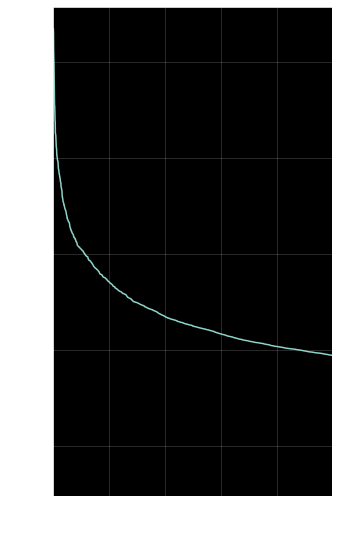

In [115]:
zs = sorted(df_new[fp]['Z_max'])[::-1]
plt.figure(figsize=(5, 9))
plt.plot(100 * np.arange(len(zs)) / len(zs), zs)
plt.xlim((0, 10))
plt.grid(alpha=0.2)
plt.ylabel('dyn max')
plt.xlabel('Percent of false positives')
plt.show()

In [119]:
R, C = 6, 6
ylim_constant=False
xlim_constant=True
legend=True
plot_x=True
lifetime_max = np.max(df.lifetime.values[:R * C])

In [120]:
np.linspace(0, df_new.shape[0], R*C - 1)
d = df_new.sort_values('Z_max').iloc[np.linspace(35000, df_new.shape[0] - 1, R*C).astype(int)]

In [ ]:
plt.figure(figsize=(16, 12))
for i in tqdm(range(R * C)):
    if i < d.shape[0]:
        plt.subplot(R, C, i + 1)
        row = d.iloc[i]
        if plot_x:
            plt.plot(row.X, color=cr, label='clathrin')
#         if extra_key is not None:
        plt.plot(row.Z, color=cp, label='dyn')
        plt.title(int(row.Z_max), color=cp)
        if ylim_constant:
            plt.ylim([-10, max(max(d.X_max), max(d.Y_max)) + 1])
        plt.xticks([])
plt.tight_layout()